## Report for Project "Continuous Control"
### 1. Problem Statement
The environment **option 2** is chosen for this project. 20 agents are trained to achieve a target average score of **30** over **100** episodes. Each action contains 4 values, while 33 features for each state
![state action space.png](state_action_space.png)
A *Actor-Critic Method* called **D**eep **D**eterministic **P**olicy **G**radient (DDPG) is implemented in this project. [see paper](http://arxiv.org/pdf/1509.02971.pdf). The single DDPG [agent](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py) and [model](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/model.py) are reused as starting point. The adaptation and improvements of the agent and model are described in the following sections of this report.
#### Actor-Critic Method
Value-based methods, such like Deep Q Network (DQN), are helping the agent to find a optimal state action value and the goal is to maxmimize the cumulative rewards. During the learning process, the agent will firstly estimate the expected return using a target DQN and the current return using a local DQN. After learning, the weights of local DQN are copied to the target DQN. As a result, the estimation by target is depending on the previous learning step. So, the value-based approach is bias.
On the other hand, the policy-based methods, e.g. DDPG, are training the agent with state-action pair using gradient ascent. The goal is thus to directly find a optimal policy. Using the policy-based methods, the learning is less bias but with more variance. Actor-Critic method leverage the stengths of both policy-based and value-based methods, with more efficiency on the learning process, while the agent trained by this method is more stable.
#### Replay buffer
After each step, the tuple $(s_t, a_t, r_t, s_{i+1})$ are stored to a buffer called "experience", which are uniformly sampled to get a minibatch for the next learning. This uniformly sampling breaks the correlations of each state action transition.
#### Soft update
The weights of target networks $\theta'$ are updated by slowly tracking the learned network $\theta$.
$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

### 2. Model architecture
The model for both **Actor** and **Critic** consists of 3 fully connected layers with **521** hidden nodes for the first layer and **256** for the second one. I tried 256 and 128 nodes with the same hyperparameters, the scores were increasing slowly and it didn't reach the target average score (+30), even after long training time. Afterwards, I decided to increase the number of hidden node to increase the model capacity, it works better.
Batch normalization is used for increasing the efficiency, while clipping the gradient on training for avoiding gradient explosion

### 3. Hyperparameters of Agent
According to the project benchmark, it is decided to train the agents **10** times for every **20** time steps, to stabilize the average scores while garanteeing the training efficiency. To trade off the exploration and exploitation, *EPSILON* is set initially and decayed by a factor *EPSILON_DECAY*, the benifit is to start the training with exploring more possible actions in the environment, since the agent didn't get much experience yet, but during the training with more episodes, the agent is more experienced, decaying epsilon can help agent exploit more.

In [4]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay

LEARN_EVERY = 20
LEARN_NUM = 10

EPSILON = 1.0
EPSILON_DECAY = 0.99999

### 4. Training Result
Run the following cells, it can be seen that, we solved the problem after **203** episodes and got the average score of **30.03** over 100 episodes.
There are still some potential improvements, for example, seeing the training process, the difference of minimum score and maximum score of the 20 agents is still large, even after 190 episodes. It can be a reason that the epsilon factor of the noises used for sampling actions is not decayed well, the parameter *EPSILON_DECAY* could be decreased a little bit so that the *EPSILON* can be converged more faster and the training might be more efficient

![action noises](./noises.png)

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

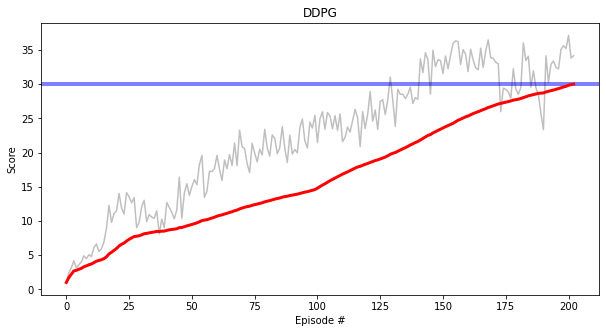

In [2]:
scores_path = './scores.pickle'
scores_mean_path = './scores_mean.pickle'
with open(scores_path, 'rb') as f:
    scores_result = pickle.load(f)
with open(scores_mean_path, 'rb') as f:
    scores_mean_result = pickle.load(f)

fig, ax = plt.subplots(1, 1, figsize=[10, 5])

ax.axhline(30, c="blue", linewidth=4, alpha=0.5)
ax.plot(scores_result, "-", c="black", alpha=0.25)
ax.plot(scores_mean_result, "-", c="red", linewidth=3)

ax.set_xlabel("Episode #")
ax.set_ylabel("Score")
ax.set_title("DDPG")

plt.show()

### 5. Watch the result in Unity

changing the path of the environment and running the block, the result can be watched in Unity.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
from ddpg_agent import Agent

In [2]:
#select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='./Reacher.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents, action and state size
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)

    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 35.27199921160936


In [10]:
env.close()

The screenshot from Unity is shown in the following.
![unity result](unity_result.png)

### 6. Further Works
The following works could be done in the future to improve the solution and training efficiency:
1. Tuning the parameter *EPSILON_DECAY* to accelerate the training
2. Prioritizing the experience
3. Try other approach like **Proximal Policy Optimization**